## Deep learning example with GradientExplainer (TensorFlow/Keras/PyTorch models)

Expected gradients combines ideas from Integrated Gradients, SHAP, and SmoothGrad into a single expected value equation. This allows an entire dataset to be used as the background distribution (as opposed to a single reference value) and allows local smoothing. If we approximate the model with a linear function between each background data sample and the current input to be explained, and we assume the input features are independent then expected gradients will compute approximate SHAP values. In the example below we have explained how the 7th intermediate layer of the VGG16 ImageNet model impacts the output probabilities.

In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

Using TensorFlow backend.


In [3]:
# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [4]:
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)


In [5]:
# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

In [6]:
index_names

array([['dowitcher', 'red-backed_sandpiper'],
       ['meerkat', 'mongoose']], dtype='<U20')

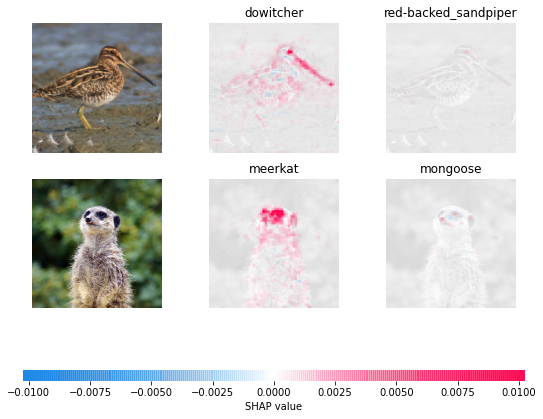

In [7]:
# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

Predictions for two input images are explained in the plot above. Red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class. By using ranked_outputs=2 we explain only the two most likely classes for each input (this spares us from explaining all 1,000 classes).

## Model agnostic example with KernelExplainer (explains any function)

Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model. Below is a simple example for explaining a multi-class SVM on the classic iris dataset.

In [1]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

In [2]:
# train a SVM classifier
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

SVC(probability=True)

In [3]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/30 [00:00<?, ?it/s]

In [39]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

The above explanation shows four features each contributing to push the model output from the base value (the average model output over the training dataset we passed) towards zero. If there were any features pushing the class label higher they would be shown in red.

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset. This is exactly what we do below for all the examples in the iris test set:

In [40]:
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")